# VISST data viewer

This code views data from VISST netcdf files created by Patrick Minnis. 

In [7]:
# Load required libraries
from netCDF4 import Dataset
import numpy as np
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import datetime
import math
import glob
import os
from parse import *
%matplotlib inline

In [14]:
# Input the range of dates and time wanted for the collection of images
year = 2006
start_day = 8
start_month = 1
start_hour = 21
start_minute = 0
start_second = 0

end_month = 1
end_day = 8
end_hour = 22
end_minute = 00
end_second = 00

start_time = datetime.datetime(year,
                               start_month,
                               start_day,
                               start_hour,
                               start_minute,
                               start_second)
end_time = datetime.datetime(year,
                             end_month,
                             end_day,
                             end_hour,
                             end_minute,
                             end_second)
deltatime = end_time - start_time


if(deltatime.seconds > 0 or deltatime.minute > 0):
    no_days = deltatime.days + 1
else:
    no_days = deltatime.days

days = np.arange(0, no_days, 1)
print('We are about to load grid files for ' + str(no_days) + ' days')
data_path = '/home/rjackson/data/visst/'

# Find the list of files for each day
cur_time = start_time

file_list = []
time_list = []
for i in days:
    year_str = "%04d" % cur_time.year
    day_str = "%02d" % cur_time.day
    month_str = "%02d" % cur_time.month
    print('Looking for files with format ' +
          data_path +
          'twpvisstpx04*' +
          year_str +
          month_str +
          day_str +
          '*.cdf')
    data_list = glob.glob(data_path +
                          'twpvisstpx04*' +
                          year_str +
                          month_str +
                          day_str +
                          '*.cdf')
    file_list.append(data_list[0])
    time_list.append(cur_time)
    cur_time = cur_time + datetime.timedelta(days=1)

We are about to load grid files for 1 days
Looking for files with format /home/rjackson/data/visst/twpvisstpx04*20060108*.cdf


# VISST pixel level file:

Variable Details for File: twpvisstpx04m2rv4minnisX30.c1.20141020.003200.cdf<br />
Index 	Variable Name 	Dimensions 	Units 	Variable Long Name<br />
0 	base_time 	[scalar] 	seconds since 1970-1-1 0:00:00 GMT 	base time in epoch<br />
1 	time_offset 	[time=16104] 	seconds since 2014-10-20 00:00:00 GMT 	Time offset from base_time<br />
2 	time 	[time=16104] 	seconds since 2014-10-20 00:00:00 GMT 	Time offset from midnight<br />
3 	image_times 	[index=24] 	seconds since 2014-10-20 00:00:00 GMT 	Image times offset from base time<br />
4 	image_start 	[index=24] 	n/a 	Image start index<br />
5 	image_numpix 	[index=24] 	n/a 	Number of pixels for each image<br />
6 	latitude 	[time=16104] 	deg 	north latitude<br />
7 	longitude 	[time=16104] 	deg 	east longitude<br />
8 	reflectance_vis 	[time=16104] 	unitless 	Visible reflectance (0.65 um)<br />
9 	reflectance_nir 	[time=16104] 	unitless 	Near Infrared reflectance (1.6 um)<br />
10 	temperature_sir 	[time=16104] 	K 	Solar Infrared temperature (3.9 um)<br />
11 	temperature_ir 	[time=16104] 	K 	Infrared Channel temperature (10.8 um)<br />
12 	temperature_sw 	[time=16104] 	K 	Split-Window Channel temperature (11.9 um)<br />
13 	broadband_shortwave_albedo 	[time=16104] 	% 	broadband SW albedo<br />
14 	broadband_longwave_flux 	[time=16104] 	W/m^2 	broadband LW flux<br />
15 	ir_cloud_emittance 	[time=16104] 	unitless 	IR cloud emittance<br />
16 	cloud_phase 	[time=16104] 	unitless 	cloud phase<br />
17 	visible_optical_depth 	[time=16104] 	unitless 	cloud optical depth<br />
18 	particle_size 	[time=16104] 	microns 	effective particle radius or diameter<br />
19 	liquid_water_path 	[time=16104] 	g/m^2 	Liquid or Ice Water Path<br />
20 	cloud_effective_temperature 	[time=16104] 	K 	Effective cloud temperature<br />
21 	cloud_top_pressure 	[time=16104] 	hPa 	cloud top pressure<br />
22 	cloud_effective_pressure 	[time=16104] 	hPa 	Effective cloud pressure<br />
23 	cloud_bottom_pressure 	[time=16104] 	hPa 	cloud bottom pressure<br />
24 	cloud_top_height 	[time=16104] 	km 	cloud top height<br />
25 	cloud_effective_height 	[time=16104] 	km 	cloud effective height<br />
26 	cloud_bottom_height 	[time=16104] 	km 	cloud bottom height<br />
28 	DOY 	[time=16104] 	days 	GMT Day of Year<br />
29 	gmthour 	[time=16104] 	hours 	GMT Hour<br />


In [15]:
# Find the index in the file that is closest to the timestamp you specify
def find_closest_timestep_index(scan_hour, scan_minute, scan_second=0):

    time_stamp = datetime.datetime(year,
                                   month,
                                   day,
                                   scan_hour,
                                   scan_minute,
                                   scan_second)
    indicies = np.arange(1, len(Time))

    # Set the initial value for minimum difference between scan time
    # and input time to be unrealistically large (> 1 day)
    min_delta_time = datetime.timedelta(40)
    for i in indicies:
        hours = math.floor(Time[i]/3600)
        minutes = math.floor((Time[i] - hours*3600)/60)
        seconds = Time[i] - hours*3600 - minutes*60
        temp = datetime.datetime(year,
                                 month,
                                 day,
                                 int(hours),
                                 int(minutes),
                                 int(seconds))
        delta_time = abs(temp - time_stamp)
        if(delta_time < min_delta_time):
            min_delta_time = delta_time
            lowest_index = i

    return lowest_index


# Convert seconds to midnight to a string format
def seconds_to_midnight_to_string(time_secs_after_midnight):

    hours = math.floor(time_secs_after_midnight/3600)
    minutes = math.floor((time_secs_after_midnight - hours*3600)/60)
    temp = datetime.time(int(hours), int(minutes), )
    return temp.strftime('%H%M%S')


# Convert degrees minutes seconds to decimal
def dms_to_decimal(deg, minutes, seconds):
    return deg+minutes/60+seconds/3600


Since time is in seconds after midnight, we need to use datetime to convert it to HH:MM:SS for the plot. These functions look for the closest timestep to the specified time.

Plot the satellite image loop over Darwin. Right now, the grid is centered in a 500 km by 500 km over the TWP site in Darwin.

TWP Darwin Location: 12° 25' 28.56" S, 130° 53' 29.75" E

Domain:125.0 136.0-17.0 -5.0
Domain:125.0 136.0-17.0 -5.0
Domain:125.0 136.0-17.0 -5.0
Domain:125.0 136.0-17.0 -5.0
Domain:125.0 136.0-17.0 -5.0
Domain:125.0 136.0-17.0 -5.0
Domain:125.0 136.0-17.0 -5.0


KeyboardInterrupt: 

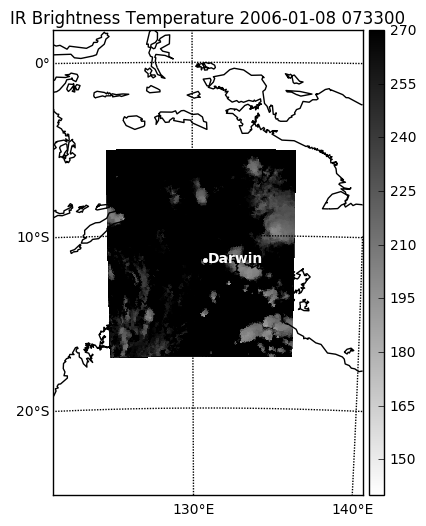

In [16]:
figure = plt.figure(figsize=(8, 6))
for i in days:
    cdf_data = Dataset(file_list[i], mode='r')

    # Load lat, lon, and time parameters
    Latitude = cdf_data.variables['latitude']
    Longitude = cdf_data.variables['longitude']
    Time = cdf_data.variables['image_times']
    NumPixels = cdf_data.variables['image_numpix']
    

    # Load brightness temperature
    IRBrightness = cdf_data.variables['temperature_ir']

    frames = np.arange(0, len(Time), 1)
    Darwin_Lat = dms_to_decimal(-12, 25, 28.56)
    Darwin_Lon = dms_to_decimal(130, 53, 29.75)

    # Do loop for each frame in the time period
    start_secs_after_midnight = (start_hour*3600
                                 + start_minute*60
                                 + start_second)
    
    end_secs_after_midnight = end_hour*3600 + end_minute*60 + end_second
    for j in frames:
        if ((i == len(days) - 1 and (Time[j] < end_secs_after_midnight)) or
                (i == 0 and (Time[j] > start_secs_after_midnight)) or
                (i > 0 and i < len(days) - 1)):
            # Get Lat and Lon for specific frame
            Lat = Latitude[(int(j)*int(NumPixels[j])):(int(j+1)*int(NumPixels[j])-1)]
            Lon = Longitude[(int(j)*int(NumPixels[j])):(int(j+1)*int(NumPixels[j])-1)]
            
            # Set up projection
            plt.clf()
            m = Basemap(width=2000000, height=3000000,
                        resolution='l', projection='stere',
                        lat_0=Darwin_Lat,
                        lon_0=Darwin_Lon)

            xi, yi = m(Lon, Lat)
            darwin_x, darwin_y = m(Darwin_Lon, Darwin_Lat)

            # Plot data
            index = j
            data = IRBrightness[(int(j)*int(NumPixels[j])):(int(j+1)*int(NumPixels[j])-1)]
            
                 
                
                
            colors = m.pcolor(xi, yi, data, cmap='gray_r', vmin=140, vmax=270, tri='true')
            plt.text(darwin_x,
                     darwin_y,
                     'Darwin',
                     fontweight='bold',
                     color='white')
            plt.plot(darwin_x*0.98, darwin_y*1.01, 'w.')

            m.drawparallels(np.arange(-80., 81., 10.),
                            labels=[1, 0, 0, 0],
                            fontsize=10)
            m.drawmeridians(np.arange(-180., 181., 10.),
                            labels=[0, 0, 0, 1],
                            fontsize=10)
            m.drawcoastlines()
            m.drawcountries()
            m.colorbar()

            year_str = "%04d" % year
            day_str = "%02d" % time_list[i].month
            month_str = "%02d" % time_list[i].day
            plt.title('IR Brightness Temperature '
                      + str(year)
                      + '-'
                      + str(day_str)
                      + '-'
                      + str(month_str)
                      + ' '
                      + seconds_to_midnight_to_string(Time[index]))

            if not os.path.exists('./output_plots'):
                os.makedirs('./output_plots')

            plt.savefig('./output_plots/IRBrightnessTemp' +
                        str(year) +
                        str(day_str) +
                        str(month_str) +
                        seconds_to_midnight_to_string(Time[index]) +
                        '.png')
            print('Domain:' + str(np.min(Lon)) + ' ' 
                  + str(np.max(Lon)) + 
                  str(np.min(Lat))
                  + ' '
                  + str(np.max(Lat)))